### 1‑D packed‑column model for a steam‑assisted TVSA cycle from Zhu et al. (2021). 


In [2]:
# Imports and functions
import numpy as np
import math
import CoolProp.CoolProp as CP
import matplotlib.pyplot as plt
from fipy import CellVariable, FaceVariable, Grid1D, TransientTerm, DiffusionTerm, ConvectionTerm

R = 8.314  # J/mol/K

def to_Pa(bar): 
    return bar * 1e5

def to_bar(Pa):
    return Pa / 1e5

def K(C):
    return C + 273.15

In [3]:
# Column geomtery (Table 2)

R1 = 0.000525   # m (channel inner radius)
R2 = 0.000585   # m
R3 = 0.000635   # m
L  = 0.3        # m column length

# Specific surface areas (per unit length in the 1‑D formulation)
As1 = R1 / 2.0
As2 = (R2**2 - R1**2) / (2.0 * R1)
As3 = (R3**2 - R2**2) / (2.0 * R2)

# Material properties
rho_ads  = 500.0   # kg/m3 (adsorbent)
rho_wall = 2050.0  # kg/m3
Cp_ads   = 892.5   # J/(kg K)
Cp_wall  = 840.0   # J/(kg K)
k_ads    = 0.32    # W/(m K)
k_wall   = 1.2     # W/(m K)
h        = 75.0    # W/(m2 K)

# Gas property (axial dispersion), assumed same order for each species
Dax = 1.6e-5  # m^2/s

# Feed conditions
v_feed   = 0.5         # m/s
p_feed   = to_Pa(1.0)  # Pa
T_feed   = 298.15      # K
x_feed   = {'CO2': 0.0004, 'N2': 0.7818, 'O2': 0.21, 'H2O': 0.0078} #400 ppm CO2 and about 25% RH

# Purge conditions (steam, desorption step)
v_purge  = 0.3
p_purge  = to_Pa(0.4)
T_purge  = 363.15  # K (90 C)
x_purge  = { 'H2O': 1.0 }


In [4]:
# Isotherm parameters (Table 3)

T0 = 273.15     # K
p0 = 101_325.0  # Pa (1 atm)

# H2O properties
Tc_H2O = 647.3    # K
pc_H2O = 22.12e6  # Pa

# CO2 isotherm parameters
# qsat1(T) = 3.120 * exp(1.713 * (1 - T/T0))  [mol/kg]
# qsat2(T) = 1 (mol/kg'capacity' multiplier for the linear term)
b1_0 = 1.519e-7   
b2_0 = 4.226e-3   
dH1  = 57_500.0   # J/mol
dH2  = 14_500.0   # J/mol

# H2O isotherm parameters
# qsat3(T) = 1 (mol/kg multiplier for Freundlich term)
b3_0  = 3.990e-10
dH3   = 71_510.0   # J/mol
V0    = 9.405e-4   # m3/kg (limiting nanopore volume per kg adsorbent)
E_H2O = 13_253.0   # J/mol (interaction energy parameter)
m_H2O = 5.0
n_F   = 1.0        # Freundlich n

# Heats of adsorption (used in energy source term, not yet in isotherm formulas)
dH_CO2  = 55_000.0   # J/mol
dH_H2O  = 40_800.0   # J/mol



In [5]:
# Temperature dependent parameters
def qsat1(T): # Table 3
    return 3.120 * math.exp(1.713 * (1.0 - T/T0))  # mol/kg

def qsat2(T): # Table 3
    return 1.0  # mol/kg multiplier for linear term

def qsat3(T): # Table 3
    return 1.0  # mol/kg multiplier for Freundlich term

def b1(T): # eq 9
    return b1_0 * math.exp(dH1/(R*T))

def b2(T): # eq 9
    return b2_0 * math.exp(dH2/(R*T))

def b3(T): # eq 9
    return b3_0 * math.exp(dH3/(R*T))

def p0_H2O(T): # eq 10
    # saturation pressure (Pa); simplified empirical form used in the paper
    return pc_H2O * (T / Tc_H2O)**2

def v_m_H2O(T): # eq 11
    # molar volume (m3/mol); empirical form used in the paper
    return (R*Tc_H2O)/(8.0*pc_H2O) * (T/Tc_H2O)**0.6


In [6]:
# CO2 and H2O equilibrium isotherms
def qeq_CO2(T, pCO2): # eq 5 (Langmuir type at low p and linear type)
    term_lang = qsat1(T) * (b1(T) * (pCO2/p0)) / (1.0 + b1(T) * (pCO2/p0))
    term_lin  = qsat2(T) * b2(T) * (pCO2/p0)
    return term_lang + term_lin

def p_sat_H2O(T):  # Pa
    # Saturation vapor pressure using CoolProp
    return CP.PropsSI('P','T',T,'Q',0,'Water')

def pH2O_from_RH(T, RH):  # RH in [0,1]
    return RH * p_sat_H2O(T)

def qeq_H2O(T, pH2O): # eq 6 (Freundlich and Dubinin-Astakhov)
    # Freundlich term
    freundlich = qsat3(T) * b3(T) * (pH2O/p0)**(1.0/n_F)
    # Dubinin–Astakhov term
    vm = v_m_H2O(T)
    A  = (R*T)/E_H2O * math.log(p_sat_H2O(T) / max(pH2O, 1e-12)) # prevents log(0)
    DA = (V0 / vm) * math.exp(-(A**m_H2O))
    return freundlich + DA

In [7]:
# LDF kinetics
def k_LDF_CO2(T, qeq, q):
    # Adsorption: constant; Desorption: Arrhenius (paper’s piecewise)
    if qeq > q:  # adsorption direction
        return 3.5e-4
    # desorption direction
    return 6.012e9 * math.exp(-89051.0/(R*T))

In [8]:
# PDAEs
nx = 100
dx = L/nx
mesh = Grid1D(dx=dx, nx=nx)

# Gas concentration
Ci = CellVariable(name="CO2 gas concentration", mesh=mesh, value=0.0)  # mol/m3_gas
qi = CellVariable(name="CO2 solid loading", mesh=mesh, value=0.0)  # mol/kg_solid

# inlet and Boundary conditions
Ci_in = (x_feed['CO2'] * p_feed) / (R * T_feed)
Ci.constrain(Ci_in, mesh.facesLeft)
Ci.faceGrad.constrain(0.0, mesh.facesRight)

# dispersion and convection
v_faces = FaceVariable(mesh=mesh, rank=1, value=v_feed)
disp_term = DiffusionTerm(coeff=Dax, var=Ci)
conv_term = ConvectionTerm(coeff=v_faces, var=Ci)     
Cdot_transfer = CellVariable(mesh=mesh, value=0.0)
mass_balance = TransientTerm(var=Ci) == disp_term - conv_term - Cdot_transfer

In [13]:
# --- helpers for inventory & plotting ---
A_gas = math.pi * (R1**2)                     # per-channel gas cross-section [m2]
solid_per_gas = (As2/As1) * rho_ads           # kg_solid / m3_gas  (from Eq. 2 geometry)
z = mesh.cellCenters.value[0]                 # axial grid
Ci_in = (x_feed['CO2'] * p_feed) / (R * T_feed) # inlet CO2 conc [mol/m3]

def column_inventory_mol(qi_vec):
    """Total moles of CO2 in solid (per channel), using Eq. (2) geometry."""
    mol_per_vol = solid_per_gas * qi_vec              # mol/m3 gas
    return np.trapz(mol_per_vol, z) * A_gas           # mol

def bed_avg_q_mmolg(qi_vec):
    qavg = float(np.trapz(qi_vec, z) / (z[-1]-z[0]))  # mol/kg
    return 1e3 * qavg                                 # mmol/g

def snapshot_profiles(t_hist, Ci_hist, qi_hist, z_ref, num=5):
    idxs = np.linspace(0, len(Ci_hist)-1, num, dtype=int)
    fig, ax = plt.subplots()
    for k in idxs:
        ax.plot(z_ref, Ci_hist[k], label=f"t={t_hist[k]:.0f}s")
    ax.set_xlabel('z (m)'); ax.set_ylabel(r'$C_{\mathrm{CO_2}}$ (mol m$^{-3}$)')
    ax.set_title('Gas concentration profiles'); ax.grid(True, alpha=0.3); ax.legend()
    plt.show()

    fig, ax = plt.subplots()
    for k in idxs:
        ax.plot(z_ref, np.array(qi_hist[k])*1e3, label=f"t={t_hist[k]:.0f}s")
    ax.set_xlabel('z (m)'); ax.set_ylabel(r'$q_{\mathrm{CO_2}}$ (mmol kg$^{-1}$)')
    ax.set_title('Solid loading profiles'); ax.grid(True, alpha=0.3); ax.legend()
    plt.show()

In [18]:
def rate_CO2(T, Ci_cell, qi_cell):
    pCO2 = Ci_cell * R * T            # eq 3
    qstar = qeq_CO2(T, pCO2)          # mol/kg_solid
    k = k_LDF_CO2(T, qstar, qi_cell)  # 1/s
    return k * (qstar - qi_cell)      # mol/kg/s

def Cdot_transfer_CO2(T, Ci_vals, qi_vals):
    rates = np.array([rate_CO2(T, Ci, q) for Ci, q in zip(Ci_vals, qi_vals)])  # mol/kg * s
    return (As2/As1) * rho_ads * rates   # mol/m3 * s


In [41]:
# --- ADSORPTION: long run toward capacity ---
dt    = 0.05                  # s
t_end = 20000                # s
steps = int(t_end / dt)

# time-series storage
t_hist        = []
Cout_over_Ci_in = []
mol_hist_ads  = []
qavg_hist_ads = []
Ci_profiles   = []
qi_profiles   = []

# run
for step in range(steps):
    # update sink from current q
    Cdot_transfer.setValue(Cdot_transfer_CO2(T_feed, Ci.value, qi.value))
    # advance gas
    mass_balance.solve(var=Ci, dt=dt)
    # advance solid (explicit LDF)
    rates = np.array([rate_CO2(T_feed, Ci_cell, qi_cell)
                      for Ci_cell, qi_cell in zip(Ci.value, qi.value)])
    qi.setValue(qi.value + rates * dt)

# logs
    t_hist.append(step * dt)
    Cout_over_Ci_in.append(float(Ci.value[-1]) / Ci_in)
    mol_hist_ads.append(column_inventory_mol(qi.value))
    qavg_hist_ads.append(bed_avg_q_mmolg(qi.value))

    if step % max(1, steps//40) == 0:
        Ci_profiles.append(Ci.value.copy())
        qi_profiles.append(qi.value.copy())

print(f"[adsorption] final inventory: {mol_hist_ads[-1]:.3e} mol "
      f"({mol_hist_ads[-1]*44.01:.3f} g CO2 per channel)")


[adsorption] final inventory: 3.446e-05 mol (0.002 g CO2 per channel)


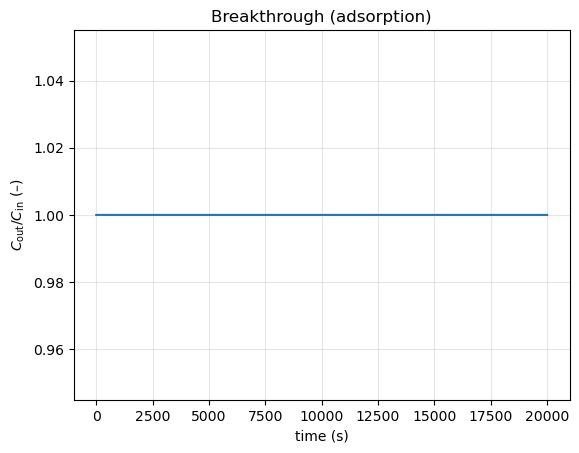

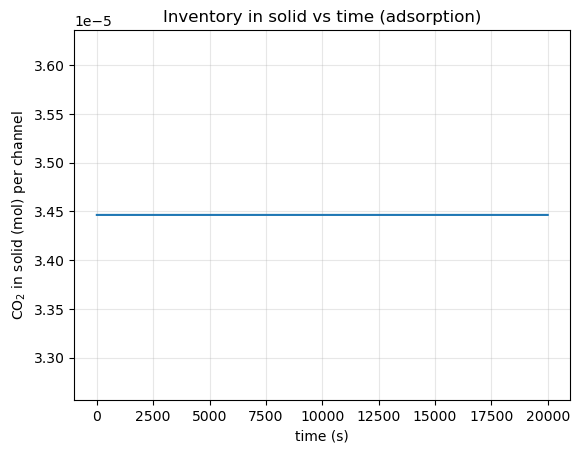

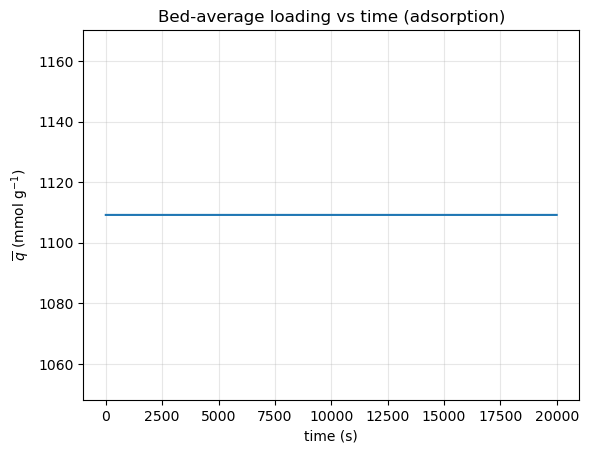

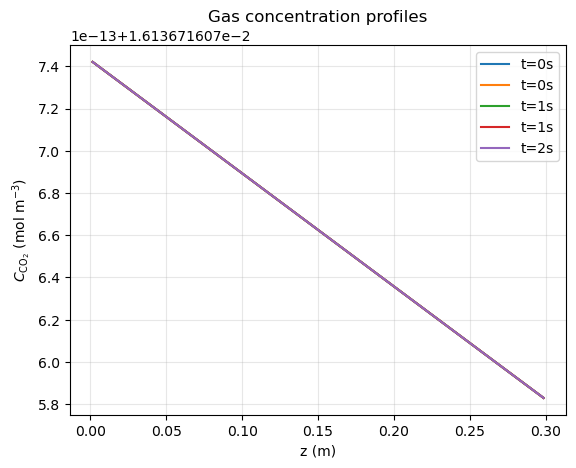

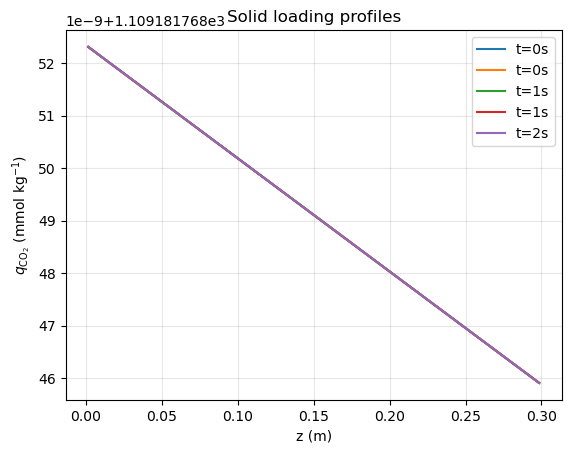

In [42]:
# breakthrough
plt.figure()
plt.plot(t_hist, Cout_over_Ci_in)
plt.xlabel('time (s)'); plt.ylabel(r'$C_{\mathrm{out}}/C_{\mathrm{in}}$ (–)')
plt.title('Breakthrough (adsorption)'); plt.grid(True, alpha=0.3); plt.show()

# inventory vs time
plt.figure()
plt.plot(t_hist, mol_hist_ads)
plt.xlabel('time (s)'); plt.ylabel('CO$_2$ in solid (mol) per channel')
plt.title('Inventory in solid vs time (adsorption)'); plt.grid(True, alpha=0.3); plt.show()

# bed-average loading vs time
plt.figure()
plt.plot(t_hist, qavg_hist_ads)
plt.xlabel('time (s)'); plt.ylabel(r'$\overline{q}$ (mmol g$^{-1}$)')
plt.title('Bed-average loading vs time (adsorption)'); plt.grid(True, alpha=0.3); plt.show()

# profile snapshots
snapshot_profiles(t_hist, Ci_profiles, qi_profiles, z)


In [43]:
# --- DESORPTION set-up (evacuation-style) ---
# copy final adsorption state
Ci_des = CellVariable(name="CO2 gas conc (des)", mesh=mesh, value=Ci.value.copy())
qi_des = CellVariable(name="CO2 solid loading (des)", mesh=mesh, value=qi.value.copy())

# BCs per a simple evacuation model:
# inlet z=0: zero gradient; outlet z=L: Dirichlet low CO2 (vacuum-side)
Ci_des.faceGrad.constrain(0.0, mesh.facesLeft)
p_vac   = to_Pa(0.01)               # 0.01 bar at the pump, tweak as desired
Ci_in_vac = (1e-6 * p_vac) / (R * T_feed)  # ~1 ppm CO2 at outlet under vacuum (choose your target)
Ci_des.constrain(Ci_in_vac, mesh.facesRight)

# zero bulk flow during evacuation (you can also try a small negative velocity)
v_faces_des = FaceVariable(mesh=mesh, rank=1, value=0.0)

# PDE for desorption (same operator, new unknowns and v)
Cdot_transfer_des = CellVariable(mesh=mesh, value=0.0)
mass_balance_des = (TransientTerm(var=Ci_des)
                    == DiffusionTerm(coeff=Dax, var=Ci_des)
                     - ConvectionTerm(coeff=v_faces_des, var=Ci_des)
                     - Cdot_transfer_des)


In [44]:
# --- DESORPTION run ---
dt_des    = 0.05
t_end_des = 600.0        # 10 minutes, tweak as needed
steps_des = int(t_end_des / dt_des)

t_hist_des        = []
Cout_over_Cvac    = []
mol_hist_des      = []
qavg_hist_des     = []
Ci_profiles_des   = []
qi_profiles_des   = []

for step in range(steps_des):
    # update sink with current q (note: q_eq depends on local pCO2)
    Cdot_transfer_des.setValue(Cdot_transfer_CO2(T_feed, Ci_des.value, qi_des.value))

    # gas update
    mass_balance_des.solve(var=Ci_des, dt=dt_des)

    # solid update (explicit LDF, now likely in desorption regime so k is Arrhenius)
    rates_des = np.array([rate_CO2(T_feed, Ci_cell, qi_cell)
                          for Ci_cell, qi_cell in zip(Ci_des.value, qi_des.value)])
    qi_des.setValue(qi_des.value + rates_des * dt_des)

    # logs
    t = step * dt_des
    t_hist_des.append(t)
    Cvac = float(Ci_des.value[-1])  # this should be close to Ci_in_vac by constraint
    Cout_over_Cvac.append(float(Ci_des.value[0]) / max(Ci_in, 1e-30))  # compare inlet (z=0) to original Ci_in
    mol_hist_des.append(column_inventory_mol(qi_des.value))
    qavg_hist_des.append(bed_avg_q_mmolg(qi_des.value))

    if step % max(1, steps_des//40) == 0:
        Ci_profiles_des.append(Ci_des.value.copy())
        qi_profiles_des.append(qi_des.value.copy())

print(f"[desorption] final inventory: {mol_hist_des[-1]:.3e} mol "
      f"({mol_hist_des[-1]*44.01:.3f} g CO2 per channel)")


[desorption] final inventory: 3.446e-05 mol (0.002 g CO2 per channel)


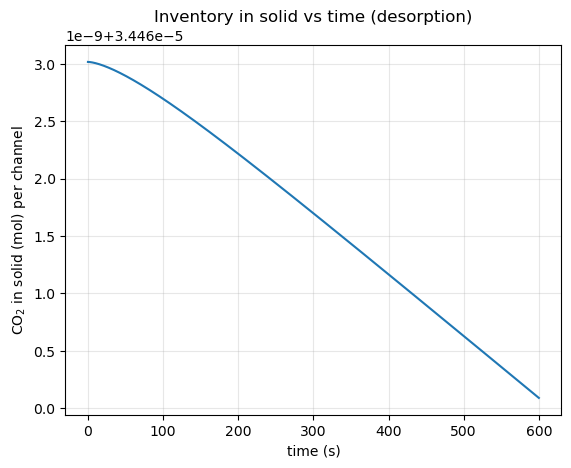

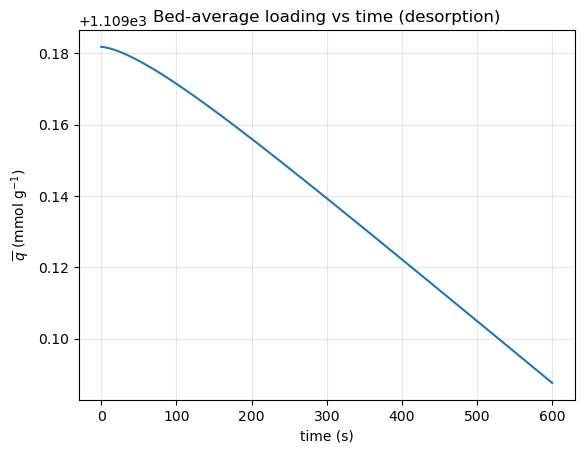

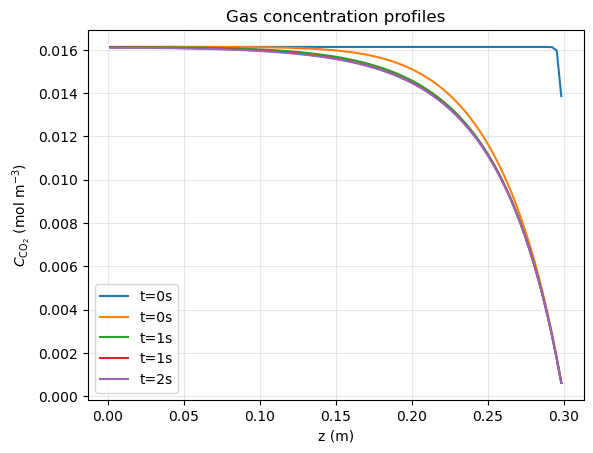

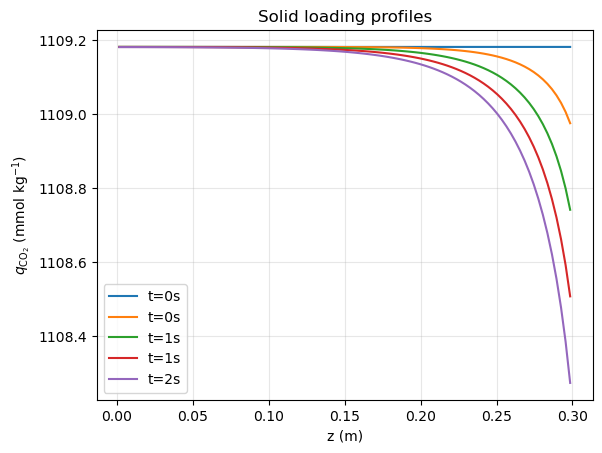

In [45]:
# total inventory vs time (should decrease toward ~0)
plt.figure()
plt.plot(t_hist_des, mol_hist_des)
plt.xlabel('time (s)'); plt.ylabel('CO$_2$ in solid (mol) per channel')
plt.title('Inventory in solid vs time (desorption)'); plt.grid(True, alpha=0.3); plt.show()

# bed-average q vs time
plt.figure()
plt.plot(t_hist_des, qavg_hist_des)
plt.xlabel('time (s)'); plt.ylabel(r'$\overline{q}$ (mmol g$^{-1}$)')
plt.title('Bed-average loading vs time (desorption)'); plt.grid(True, alpha=0.3); plt.show()

# profiles during desorption
snapshot_profiles(t_hist_des, Ci_profiles_des, qi_profiles_des, z)
